In [1]:
# from llm_workflow.openai import OpenAIChat

# model = OpenAIChat()

# model("hello")

In [6]:
# load yaml file

from abc import ABC, abstractmethod
from textwrap import dedent
from pydantic import BaseModel, field_validator
import yaml
from enum import Enum

# enum Priority
class Priority(str, Enum):
    low = 'low'
    medium = 'medium'
    high = 'high'


class Note(ABC, BaseModel):
    priority: Priority = Priority.medium
    reference: str | None = None
    tags: list[str] = []

    def uuid(self) -> str:
        """Return a unique identifier for the note (e.g. a hash of the content)."""
        return str(hash('-'.join([f"{k}={v}" for k, v in self.dict().items()])))

    @abstractmethod
    def preview(self):
        """Render the 'preview' e.g. the 'question' or 'term' to give context."""

    @abstractmethod
    def note(self):
        """Render the 'description' e.g. the 'answer' or 'definition' to provide more detail."""


class TextNote(Note):
    text: str

    @field_validator('text')
    @classmethod
    def text_validator(cls, t: str) -> str:
        return dedent(t).strip()

    def preview(self):
        return self.text

    def note(self):
        return self.text


class DefinitionNote(Note):
    term: str
    definition: str

    @field_validator('term')
    @classmethod
    def term_validator(cls, t: str) -> str:
        return dedent(t).strip()
    
    @field_validator('definition')
    @classmethod
    def definition_validator(cls, d: str) -> str:
        return dedent(d).strip()

    def preview(self):
        return self.term

    def note(self):
        return self.definition


class QuestionAnswerNote(Note):
    question: str
    answer: str

    @field_validator('question')
    @classmethod
    def term_validator(cls, q: str) -> str:
        return dedent(q).strip()
    
    @field_validator('answer')
    @classmethod
    def definition_validator(cls, a: str) -> str:
        return dedent(a).strip()

    def preview(self):
        return self.question

    def note(self):
        return self.answer  


class ClassNotes(BaseModel):
    uuid: str
    subject_metadata: dict = {}
    note_metadata: dict = {}
    notes: list[Note] = []

    @classmethod
    def from_dict(cls, data: dict):
        """Create a ClassNotes object from a dictionary."""
        notes = []
        for note in data['notes']:
            if isinstance(note, str):
                notes.append(TextNote(text=note))
            elif isinstance(note, dict):
                if 'text' in note:
                    notes.append(TextNote(**note))
                elif 'term' in note and 'definition' in note:
                    notes.append(DefinitionNote(**note))
                elif 'question' in note and 'answer' in note:
                    notes.append(QuestionAnswerNote(**note))
                else:
                    raise ValueError(f"Invalid note type: {note}")
            else:
                raise ValueError(f"Invalid note type: {note}")
        data['notes'] = notes
        return ClassNotes(**data)


with open("../../tests/test_files/notes1.yaml", "r") as f:
    notes = yaml.safe_load(f)


class_notes = ClassNotes.from_dict(notes)
print(class_notes)

uuid='65A67658-8B85-41CF-8FCF-1A1D46F61690' subject_metadata={'category': 'OMSCS', 'ident': 'CS 6200', 'name': 'Graduate Introduction to Operating Systems', 'abbreviation': 'GIOS'} note_metadata={'source': "Beej's Guide to Network Programming", 'url': 'https://beej.us/guide/bgnet/pdf/bgnet_usl_c_1.pdf', 'tags': ['systems', 'c', 'networking']} notes=[DefinitionNote(priority=<Priority.medium: 'medium'>, reference=None, tags=[], term='What is a **socket**?', definition='A way to speak to other programs using standard Unix file descriptors.'), DefinitionNote(priority=<Priority.medium: 'medium'>, reference=None, tags=[], term='What is a file descriptor?', definition="An integer associated with an open file. But (and here's the catch), that file can be a `network connection`, a `FIFO`, a `pipe`, a `terminal`, a real on-the-disk `file`, or just about anything else.  Everything in Unix *is* a file.\n\nA file descriptor is a **small, non-negative integer** that a Unix or Unix-like operating sys

In [59]:
import numpy as np
from dataclasses import dataclass


@dataclass
class History:
    correct: int = 0
    incorrect: int = 0

    def beta_draw(self):
        """
        Draw a sample from the beta distribution. The interpretation is the probability of
        "success" (in this case successfully answering the question correctly). The higher the
        likelihood of success, the less likely we need to study this note.
        """
        return np.random.beta(self.correct + 1, self.incorrect + 1, 1)[0]

    def correct_answer(self, correct: bool) -> None:
        if correct:
            self.correct += 1
        else:
            self.incorrect += 1


class TestBank:
    def __init__(self, class_notes: list[ClassNotes], history: dict[str, History] | None = None):
        self.test_bank = {}
        for class_note in class_notes:
            for note in class_note.notes:
                uuid = class_note.uuid + note.uuid()
                assert uuid not in self.test_bank, f"Duplicate UUID: {uuid}"
                self.test_bank[uuid] = {
                    'history': history[uuid] if history and uuid in history else History(),
                    'subject_metadata': class_note.subject_metadata,
                    'note_metadata': class_note.note_metadata,
                    'note': note,
                }

    def draw(self) -> dict:
        """Draw a note from the class notes."""
        probabilities = {
            k: v['history'].beta_draw()
            for k, v in self.test_bank.items()
        }
        # softmax probabilities across all values
        sum_probs = sum(probabilities.values())
        probabilities = {k: v / sum_probs for k, v in probabilities.items()}
        # draw a note
        uuid = np.random.choice(list(probabilities.keys()), p=list(probabilities.values()))
        return self.test_bank[uuid]

    def get_history(self):
        return {k: v['history'] for k, v in self.test_bank.items()}


test = TestBank([class_notes])
draw = test.draw()
draw

{'history': History(correct=0, incorrect=0),
 'subject_metadata': {'category': 'OMSCS',
  'ident': 'CS 6200',
  'name': 'Graduate Introduction to Operating Systems',
  'abbreviation': 'GIOS'},
 'note_metadata': {'source': "Beej's Guide to Network Programming",
  'url': 'https://beej.us/guide/bgnet/pdf/bgnet_usl_c_1.pdf',
  'tags': ['systems', 'c', 'networking']},
 'note': TextNote(priority=<Priority.medium: 'medium'>, reference='ChatGPT', tags=[], text='When a **file** or **resource** is opened by a process, the operating system creates an **entry** to represent that file or resource and returns a **file descriptor**, which can then be used in further system calls to read from, write to, or manipulate the file or resource.\n\n* File descriptors are used by the operating system to manage the details of input/output operations without exposing the underlying complexity to programs. Typically, file descriptors refer to: **File descriptor 0**: Standard input (stdin). **File descriptor 1**:

In [60]:
draw['history'].correct_answer(True)

In [61]:

test.get_history()

{'65A67658-8B85-41CF-8FCF-1A1D46F61690-7171266355068618968': History(correct=0, incorrect=0),
 '65A67658-8B85-41CF-8FCF-1A1D46F61690-3890729400290021629': History(correct=0, incorrect=0),
 '65A67658-8B85-41CF-8FCF-1A1D46F616906884738064011858029': History(correct=1, incorrect=0)}

(0.0, 1.0)

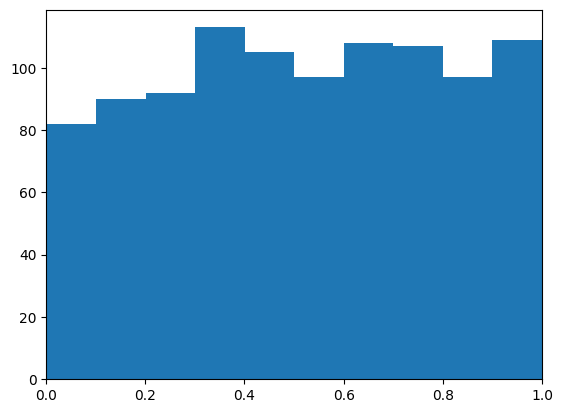

In [13]:
# use beta distribution to draw notes
import numpy as np
import matplotlib.pyplot as plt

# beta distribution
correct, wrong = 0, 0
# beta is the distribution of the probability of success
beta = np.random.beta(correct + 1, wrong + 1, 1000)
# if the probability of success (of answering the question) is high, then there is less need to study it and we can draw it less often
beta = 1 - beta
plt.hist(beta, bins=10)
# fix the x-axis between 0 and 1
plt.xlim(0, 1)